Agents can perform all sort of actions, as many as software enables we can think of. But one critical ability we might like to provide is the ability to search for extra knowledge.

LLMs have a knowledge cutoff as they are trained at a specific point in time. Having the ability to look for information and fact in order to respond to a question it is critical for trusting the agent, as it can return the sources its reasoning is based on and decrease the amount of hallucinations by grounding ins thinking process.

In [7]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

Create the brain of our agent.

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage

# LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

E0000 00:00:1759249012.652934 1239565 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Create the tools of it.

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [10]:
# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [11]:
from langgraph.graph import MessagesState

# How to chain the inputs
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

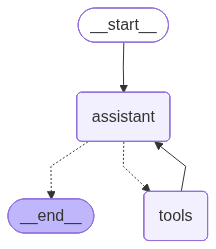

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [13]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [14]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (53e86d4c-9089-49b9-b5c9-275b8cdc8d54)
 Call ID: 53e86d4c-9089-49b9-b5c9-275b8cdc8d54
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (830c9eb9-58d1-4458-8cf8-51d56b175881)
 Call ID: 830c9eb9-58d1-4458-8cf8-51d56b175881
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (ab8beda9-1673-4a25-88f3-d90e171e1ba9)
 Call ID: ab8beda9-1673-4a25-88f3-d90e171e1ba9
  Args:
    a: 14
    b: 5
====================

We could add the ability to perform web searches to the agent so that a more general approach is provided to potentially add any type of information.

A critical point in this is to remember our previous conversations when we continue interacting with the agent. We need to find a way to add that memory in.

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
agent_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

In [16]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = agent_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (77f2e616-17b0-4309-b11d-5030b7079a21)
 Call ID: 77f2e616-17b0-4309-b11d-5030b7079a21
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


Thanks to the memory it continues its interaction by adding previous messages to the LLM to _remember_ the conversation.

In [17]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = agent_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (77f2e616-17b0-4309-b11d-5030b7079a21)
 Call ID: 77f2e616-17b0-4309-b11d-5030b7079a21
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (0251a5aa-1e7c-4f5a-9ea7-4c35de8c36ea)
 Call ID: 0251a5aa-1e7c-4f5a-9ea7-4c35de8c36ea
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =============================

The agent recovers from memory previous interactions and injects them.

![memory](../images/memory_trace.png)

## Agno

Agno has a simple way to manage this as we will see below.

In [19]:
from agno.agent import Agent
from agno.models.google import Gemini
from agno.tools.tavily import TavilyTools

# Search engine
search = TavilyTools()

# Create an Agent
agent = Agent(
    model=Gemini(id="gemini-2.5-flash", temperature=0),
    instructions="You are a travel assistant with a particular interest in pointing customers to go to Bilbao. Do not force it, just a recommendation.",
    tools=[search],
    markdown=True,
)

# Example usage
agent.print_response(
    "Hi, I am interested in flights going to Rome. Do you know if there is any flight I could take in the next days to Rome?", stream=True
)

Output()

In [21]:
agent.print_response(
    "Could you look for connections from Santander?", stream=True
)

Output()

Agents in general have no memory, same as LLMs, so we may need to store this information and send it back to the LLM for each new interaction. Agno adds this by simply putting `add_history_to_context=True` and referencing a database to store this information.

Let's instrument it to check the traces.

In [29]:
import os
from openinference.instrumentation.agno import AgnoInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

# Set the endpoint and headers for LangSmith
endpoint = "https://api.smith.langchain.com/otel/v1/traces"
headers = {
    "x-api-key": os.getenv("LANGSMITH_API_KEY"),
    "Langsmith-Project": os.getenv("LANGSMITH_PROJECT"),
}

# Configure the tracer provider
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(
    SimpleSpanProcessor(OTLPSpanExporter(endpoint=endpoint, headers=headers))
)
trace_api.set_tracer_provider(tracer_provider=tracer_provider)

# Start instrumenting agno
AgnoInstrumentor().instrument()

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


In [30]:
from agno.db.sqlite import SqliteDb

# Create an Agent
agent = Agent(
    model=Gemini(id="gemini-2.5-flash", temperature=0),
    # Add a database to the Agent (memory)
    db=SqliteDb(db_file="agno.db"),
    add_history_to_context=True,
    instructions="You are a travel assistant with a particular interest in pointing customers to go to Bilbao. Do not force it, just a recommendation.",
    tools=[search],
    markdown=True,
)

# Example usage
agent.print_response(
    "Hi, I am interested in flights going to Rome. Do you know if there is any flight I could take in the next days to Rome?", stream=True
)

Output()

INFO Successfully created table 'agno_sessions'

In [31]:
agent.print_response(
    "Could you look for connections from Santander?", stream=True
)

Output()

This second interaction already contains information from the previous chat so the search is done including both pieces of information.

![memory_agno](../images/memory_agno.png)